In [1]:
import os, cv2
from PIL import Image, ImageOps
import pickle
import imutils
from tqdm import tqdm
from time import *
import numpy as np
import math
import h5py
import timeit
from random import shuffle
import matplotlib.pyplot as plt
import keras.utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing 
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import glob

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
check_dir = os.getcwd() + '/drive/My Drive/'
if 'Academics' in os.listdir(check_dir): # Niraj drive
  root_dir = '/content/drive/My Drive/Academics/Sem1/682/'
else: # Anirudh drive
  root_dir = '/content/drive/My Drive/'

In [4]:
dataset_path = root_dir + 'CS682 Project/Final/Dataset/data_128/'
results_path = root_dir + 'CS682 Project/Final/Results/'
models_path = root_dir + 'CS682 Project/Final/Models/'

fish_path = dataset_path + 'Fish/'
bg_path = dataset_path + 'Background/'
lamprey_path = dataset_path + 'Lamprey/'

fish_img = glob.glob(f'{fish_path}*')[:]
lamprey_img = glob.glob(f'{lamprey_path}*')[:]
bg_img = glob.glob(f'{bg_path}*')[:]

print("# of Fish images :", len(fish_img))
print("# of Lamprey images :", len(lamprey_img))
print("# of Background images :", len(bg_img))

# of Fish images : 5081
# of Lamprey images : 5110
# of Background images : 2477


**Class labels**

Background - 0 <br/>
Fish - 1 <br/>
Lamprey - 2

**Data Augmentation**:


* 2 mirrors
* 3 rotations
* grey-scale 



**Data Augmentation:**

In [0]:
def augmentData(X, y):

  X_gen, y_gen = [], []

  datagen = ImageDataGenerator(horizontal_flip = True, 
                              vertical_flip = True, 
                              featurewise_center=True,
                              featurewise_std_normalization=True)
  
  labels = np.argmax(y, axis = 1)
  fish_img, bg_img, lamprey_img = [], [], []

  # Splitting data according to classes
  for i in range(len(labels)):
    if labels[i] == 0:
      fish_img.append(X[i])
    elif labels[i] == 1:
      bg_img.append(X[i])
    else:
      lamprey_img.append(X[i])

  f = np.array(fish_img)
  b = np.array(bg_img)
  l = np.array(lamprey_img)

  # 200 indices for rotating
  ind = np.random.choice(len(f), 200)

  it = datagen.flow(f, batch_size = 128)
  for i in range(5):
    batch = it.next()
    for j in range(len(batch)):
      img = batch[j].astype('float')
      X_gen.append(img)
      y_gen.append(0)
  for index in ind:
    X_gen.append(np.rot90(X[index], k = index%3 + 1, axes = (0, 1)))
    y_gen.append(0)


  it = datagen.flow(b, batch_size = 128)
  for i in range(5):
    batch = it.next()
    for j in range(len(batch)):
      img = batch[j].astype('float')
      X_gen.append(img)
      y_gen.append(1)
  for index in ind:
    X_gen.append(np.rot90(X[index], k = index%3 + 1, axes = (0, 1)))
    y_gen.append(1)

  it = datagen.flow(l, batch_size = 128)
  for i in range(5):
    batch = it.next()
    for j in range(len(batch)):
      img = batch[j].astype('float')
      X_gen.append(img)
      y_gen.append(2)
  for index in ind:
    X_gen.append(np.rot90(X[index], k = index%3 + 1, axes = (0, 1)))
    y_gen.append(2)

  return np.array(X_gen), np.array(y_gen)

In [0]:
def sampleDataset(X, y, fraction):
  bg, fish, lamprey = [], [], []

  for img, label in zip(X, y):
    label = np.argmax(label, axis = 0)
    if label==0:
      bg.append((img, label))
    if label==1:
      fish.append((img, label))
    if label==2:
      lamprey.append((img, label))

  fraction = 0.8

  smol_X = []
  smol_y = []

  fish_ind = np.random.choice(len(fish), int(fraction*len(fish)))
  for ind in fish_ind:
      smol_X.append(fish[ind][0])
      smol_y.append(fish[ind][1])

  lamprey_ind = np.random.choice(len(lamprey), int(fraction*len(lamprey)))
  for ind in lamprey_ind:
      smol_X.append(lamprey[ind][0])
      smol_y.append(lamprey[ind][1])

  for img, label in bg:
    smol_X.append(img)
    smol_y.append(label)

  smol_y = to_categorical(smol_y)

  return np.array(smol_X), np.array(smol_y)

In [0]:
def load_data(data_augmentation = False, rgb2gray = False, normalize = False, fraction = 1.0):
  ''' Function to load data
  Input: Optional parameters to augment data
  Output: Returns tuple containg X_train, y_train, X_test, y_test '''

  # Reading the .h5 file
  start = time() 
  hf = h5py.File(dataset_path + "Dataset 128x128.h5", "r")
  X = np.array(hf['images']) 
  y = np.array(hf['labels']) 
  end = time() 
  hf.close() 
  print("\nTotal time taken to read %d images = %.4f seconds" % (len(X), end - start))

  if fraction < 1.0:
    X, y = sampleDataset(X, y, fraction)

  mean_pixel, std_pixel = None, None
  
  if normalize == True:
    # normalize the data by subtracting mean and dividing by std
    mean_pixel = X.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X.std(axis=(0, 1, 2), keepdims=True)
    X = (X - mean_pixel) / std_pixel

  if data_augmentation == True: 
    start = time() 
    X_gen, y_gen = augmentData(X, y) 
    y_gen = to_categorical(y_gen)
    end = time() 
    print("\nTotal time taken to augment %d images = %.4f seconds" % (len(X), end - start)) 
    X = np.concatenate((X, X_gen)) 
    y = np.concatenate((y, y_gen))
  
  if rgb2gray == True:
    X, y = rgbGray(X, y)
    X = X[ : , : , : , np.newaxis]
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 158)

  print("\nDimensions of training data : ", X_train.shape, y_train.shape) 
  print("\nDimensions of test data : ", X_test.shape, y_test.shape)

  return X_train, y_train, X_test, y_test, mean_pixel, std_pixel

**Loading Dataset**

In [8]:
X_train, y_train, X_test, y_test, mean_pixel, std_pixel = load_data(normalize = True, fraction = 0.8)


Total time taken to read 12668 images = 147.7162 seconds

Dimensions of training data :  (7971, 128, 128, 3) (7971, 3)

Dimensions of test data :  (2658, 128, 128, 3) (2658, 3)


In [9]:
input_shape = (128, 128, 3)

model = Sequential(name = 'baseline_128x128')

model.add(Conv2D(32, (5, 5), input_shape = input_shape, padding = 'same', kernel_initializer = keras.initializers.lecun_uniform(seed = 158)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(64, (5, 5), input_shape = input_shape, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(128, (5, 5), padding = 'same')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Flatten())

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=8e-5),
              metrics=['accuracy'])

model.summary()

Model: "baseline_128x128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)   

In [10]:
checkpointer = keras.callbacks.ModelCheckpoint(models_path + 'LampNet_Baseline4_1(cb)_128x128.h5', 
                                               monitor='val_loss', verbose=1, 
                                               save_best_only=True, 
                                               save_weights_only=False, 
                                               mode='auto', period=1)


history = model.fit(X_train, y_train, batch_size = 128, epochs = 100, validation_split=0.2, shuffle = True, callbacks = [checkpointer])
model.save(models_path + 'LampNet_Baseline4_1_128x128.h5')

# Saving history
# start = time()
# hf = h5py.File(results_path + "LU_Adam(6e-5).h5", "w")
# hf.create_dataset("acc", data = history.history['acc'])
# hf.create_dataset("loss", data = history.history['loss'])
# hf.create_dataset("val_acc", data = history.history['val_acc'])
# hf.create_dataset("val_loss", data = history.history['val_loss'])
# hf.close()
# end = time()
# print("Saved training history!")

Train on 6376 samples, validate on 1595 samples
Epoch 1/100
6376/6376 [==============================] - 71s 11ms/step - loss: 0.8262 - acc: 0.6487 - val_loss: 0.6862 - val_acc: 0.6909

Epoch 00001: val_loss improved from inf to 0.68623, saving model to /content/drive/My Drive/CS682 Project/Final/Models/LampNet_Baseline4_1(cb)_128x128.h5
Epoch 2/100
6376/6376 [==============================] - 72s 11ms/step - loss: 0.5559 - acc: 0.7715 - val_loss: 0.5135 - val_acc: 0.7524

Epoch 00002: val_loss improved from 0.68623 to 0.51354, saving model to /content/drive/My Drive/CS682 Project/Final/Models/LampNet_Baseline4_1(cb)_128x128.h5
Epoch 3/100
6376/6376 [==============================] - 67s 11ms/step - loss: 0.4660 - acc: 0.8090 - val_loss: 0.4665 - val_acc: 0.7768

Epoch 00003: val_loss improved from 0.51354 to 0.46653, saving model to /content/drive/My Drive/CS682 Project/Final/Models/LampNet_Baseline4_1(cb)_128x128.h5
Epoch 4/100
6376/6376 [==============================] - 70s 11ms/st

In [11]:
print("Best val_loss = {}\nBest val_acc = {}".format(min(history.history['val_loss']), max(history.history['val_acc'])))

Best val_loss = 0.1310637090366836
Best val_acc = 0.9667711606967412


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


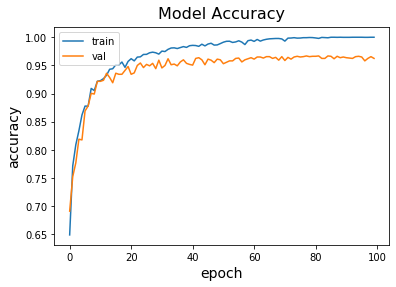

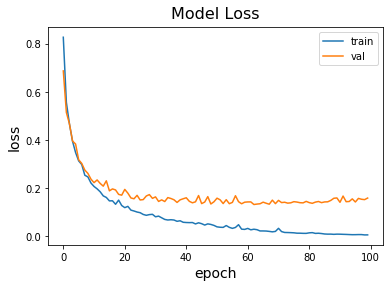

In [12]:
title_font = {'fontname':'Times', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Times', 'size':'14'}


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', **title_font)
plt.ylabel('accuracy', **axis_font)
plt.xlabel('epoch', **axis_font)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# plt.savefig(results_path + 'Accuracy plot.pdf')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', **title_font)
plt.ylabel('loss', **axis_font)
plt.xlabel('epoch', **axis_font)
plt.legend(['train', 'val'], loc='upper right')
plt.show()
# plt.savefig(results_path + 'Loss plot.pdf')

In [13]:
print("############### Stats for fully trained model ###############")
model = load_model(models_path + 'LampNet_Baseline4_1_128x128.h5')

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
y_preds1 = model.predict(X_test)
ctest, preds = np.argmax(y_test, axis = 1), np.argmax(y_preds1, axis = 1)
print("Confusion matrix : ")
print(confusion_matrix(ctest, preds))

print("############### Stats for CallBack model ###############")
model = load_model(models_path + 'LampNet_Baseline4_1(cb)_128x128.h5')

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
y_preds2 = model.predict(X_test)
ctest, preds = np.argmax(y_test, axis = 1), np.argmax(y_preds2, axis = 1)
print("Confusion matrix : ")
print(confusion_matrix(ctest, preds))

############### Stats for fully trained model ###############
Test loss: 0.14098066619539867
Test accuracy: 0.9687735139202408
Confusion matrix : 
[[642   4   6]
 [ 27 949   7]
 [ 21  18 984]]
############### Stats for CallBack model ###############
Test loss: 0.12702216957979595
Test accuracy: 0.9653875094055681
Confusion matrix : 
[[629   9  14]
 [ 27 950   6]
 [ 17  19 987]]


In [0]:
y_preds1 = np.argmax(y_preds1, axis = 1)
y_preds2 = np.argmax(y_preds2, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [15]:
print("############### Classification report for Fully trained model ###############")
print(classification_report(y_test, y_preds1, target_names = ['Background', 'Fish', 'Lamprey']) )

print("############### Classification report for CallBack model ###############")
print(classification_report(y_test, y_preds2, target_names = ['Background', 'Fish', 'Lamprey']) )

############### Classification report for Fully trained model ###############
              precision    recall  f1-score   support

  Background       0.93      0.98      0.96       652
        Fish       0.98      0.97      0.97       983
     Lamprey       0.99      0.96      0.97      1023

    accuracy                           0.97      2658
   macro avg       0.96      0.97      0.97      2658
weighted avg       0.97      0.97      0.97      2658

############### Classification report for CallBack model ###############
              precision    recall  f1-score   support

  Background       0.93      0.96      0.95       652
        Fish       0.97      0.97      0.97       983
     Lamprey       0.98      0.96      0.97      1023

    accuracy                           0.97      2658
   macro avg       0.96      0.97      0.96      2658
weighted avg       0.97      0.97      0.97      2658



In [0]:
wrong_predictions = []
for i in range(len(X_test)):
  if y_preds1[i] != y_test[i]:
    wrong_predictions.append((X_test[i], y_preds1[i], y_test[i]))
print(len(wrong_predictions))

ct = 0
for img, pred, true in wrong_predictions:
  if true == 2 and pred==1:
    plt.figure()
    img = ((img*std_pixel)+mean_pixel).reshape(128, 128, 3)
    plt.imshow(img)
    plt.title(pred)
    ct += 1
print(ct)

In [0]:
# keras.utils.plot_model(model, 'my_first_model.png')

In [0]:
# keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)